<a href="https://colab.research.google.com/github/DoreenDoreen/Natural-Language-Processing-and-Topic-Modeling-on-Product-Review/blob/main/Natural_Language_Processing_and_Topic_Modeling_on_Product_Review_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning Project - Watch Product Review Exploration and Analysis

In this project, I use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

## Contents

* [Part 1: Load Data](#Part-1:-Load-Data)
* [Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
* [Part 3: TF-IDF](#Part-3:-TF-IDF)
* [Part 4: K-means clustering](#Part-4:-K-means-clustering)
* [Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)


# Part 0: Setup Google Drive Environment

In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
!pip install -U kaleido

In [3]:
file = drive.CreateFile({'id':'14YIAzeEB11ap7OYB5wymlA-8jBrv53n6'}) # replace the id
file.GetContentFile('data.tsv')  # .tsv => tab-separated

# Part 1: Load Data

In [4]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

# from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# load data into dataframe
df = pd.read_csv('data.tsv', sep='\t', on_bad_lines = 'skip')
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [7]:
# Remove missing value
df.dropna(subset=['review_body'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960045 entries, 0 to 960044
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960045 non-null  object
 1   customer_id        960045 non-null  int64 
 2   review_id          960045 non-null  object
 3   product_id         960045 non-null  object
 4   product_parent     960045 non-null  int64 
 5   product_title      960043 non-null  object
 6   product_category   960045 non-null  object
 7   star_rating        960045 non-null  int64 
 8   helpful_votes      960045 non-null  int64 
 9   total_votes        960045 non-null  int64 
 10  vine               960045 non-null  object
 11  verified_purchase  960045 non-null  object
 12  review_headline    960032 non-null  object
 13  review_body        960045 non-null  object
 14  review_date        960041 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [9]:
# Use the first 2000 data as training data
data = df.loc[:1999, 'review_body'].to_list()

In [10]:
data[:5]

['Absolutely love this watch! Get compliments almost every time I wear it. Dainty.',
 'I love this watch it keeps time wonderfully.',
 'Scratches',
 'It works well on me. However, I found cheaper prices in other places after making the purchase',
 "Beautiful watch face.  The band looks nice all around.  The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts.  However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.<br /><br />I love the new member of my collection and it looks great.  I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch"]

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [11]:
# Use nltk's English stopwords

stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('s')
stopwords.append('m')
stopwords.append('br')
stopwords.append('watch')

In [12]:
print ("I use " + str(len(stopwords)) + " stop-words from nltk library.")
print ('The first 10 stopwords are ', stopwords[:10])

I use 183 stop-words from nltk library.
The first 10 stopwords are  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


Use my defined functions to analyze (i.e. tokenize, stem) the watch product reviews.

In [13]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

# tokenization adnd stemming
def tokenize_and_stem(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)

    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]

    return stems

In [14]:
data[0]

'Absolutely love this watch! Get compliments almost every time I wear it. Dainty.'

In [15]:
tokenize_and_stem(data[0])

['absolut',
 'love',
 'get',
 'compliment',
 'almost',
 'everi',
 'time',
 'wear',
 'dainti']

# Part 3: TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# TfidfVectorizer() function Parameter Explaination below:

# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words in the dictionary
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram

tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                              min_df=0.01, stop_words=stopwords,
                              use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data) # fit the vectorizer to synopses

# tfidf_model.get_feature_names_out()

tfidf_matrix.shape


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


(2000, 287)

In [18]:
# tfidf_model.get_feature_names_out()

In [19]:
print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 2000 reviews and 287 terms.


In [20]:
tfidf_matrix

<2000x287 sparse matrix of type '<class 'numpy.float64'>'
	with 16985 stored elements in Compressed Sparse Row format>

In [21]:
tfidf_matrix.toarray() # todense()

array([[0.        , 0.45422863, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [22]:
data[0]

'Absolutely love this watch! Get compliments almost every time I wear it. Dainty.'

In [23]:
tfidf_matrix.toarray()[0]

array([0.        , 0.45422863, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.43499265, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.39447621, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [24]:
tfidf_matrix.todense()

matrix([[0.        , 0.45422863, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [25]:
print(type(tfidf_matrix.toarray()))

<class 'numpy.ndarray'>


In [26]:
print(type(tfidf_matrix.todense()))

<class 'numpy.matrix'>


Save the terms identified by TF-IDF.

In [27]:
# words
tf_selected_words = tfidf_model.get_feature_names_out()
tf_selected_words   # print out words/Features

array(['abl', 'absolut', 'accur', 'actual', 'add', 'adjust', 'alarm',
       'almost', 'alreadi', 'also', 'although', 'alway', 'amaz', 'amazon',
       'anoth', 'appear', 'around', 'arriv', 'attract', 'automat',
       'awesom', 'back', 'bad', 'band', 'batteri', 'beauti', 'best',
       'better', 'big', 'bit', 'black', 'blue', 'bought', 'box', 'brand',
       'break', 'bright', 'broke', 'broken', 'button', 'buy', 'ca',
       'came', 'case', 'casio', 'chang', 'cheap', 'check', 'clasp',
       'classi', 'clear', 'clock', 'collect', 'color', 'come', 'comfort',
       'compliment', 'cool', 'cost', 'could', 'coupl', 'crown', 'crystal',
       'cute', 'dark', 'date', 'daughter', 'day', 'deal', 'definit',
       'deliveri', 'design', 'dial', 'differ', 'digit', 'disappoint',
       'display', 'dress', 'due', 'durabl', 'easi', 'easili', 'either',
       'eleg', 'end', 'enough', 'even', 'ever', 'everi', 'everyday',
       'everyth', 'exact', 'excel', 'expect', 'expens', 'extrem', 'face',
      

# Part 4: K-means clustering

In [28]:
# k means clustering

from sklearn.cluster import KMeans

num_clusters = 5

# number of clusters
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()  # get cluster labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## 4.1. Analyze K-means Result

In [29]:
# create DataFrame films from all of the input files.
product = { 'review': df[:2000].review_body, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])

In [30]:
frame.head(10)

,review,cluster
0,Absolutely love this watch! Get compliments al...,2
1,I love this watch it keeps time wonderfully.,3
2,Scratches,2
3,"It works well on me. However, I found cheaper ...",2
4,Beautiful watch face. The band looks nice all...,2
5,"i love this watch for my purpose, about the pe...",2
6,"for my wife and she loved it, looks great and ...",1
7,I was about to buy this thinking it was a Swis...,2
8,Watch is perfect. Rugged with the metal &#34;B...,2
9,Great quality and build.<br />The motors are r...,1


In [31]:
print ("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of reviews included in each cluster:


,count
cluster,
2,1411
1,189
3,176
0,114
4,110


In [32]:
km.cluster_centers_


#-> assumption: the value of the center point can represent this cluster
#-> The larger the tf-idf value, the more the corresponding word can represent this document
#-> The words corresponding to the 6 largest tf-idf values ​​are selected to represent this cluster

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00122121, 0.00903662,
        0.        ],
       [0.00579254, 0.00443372, 0.00527916, ..., 0.02083418, 0.01397946,
        0.00381462],
       [0.        , 0.02834811, 0.        , ..., 0.00800745, 0.        ,
        0.0103476 ],
       [0.        , 0.        , 0.        , ..., 0.00529771, 0.        ,
        0.        ]])

In [33]:
km.cluster_centers_.shape

(5, 287)

In [69]:
print ("<Document clustering result by K-means>")
print()

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Cluster_keywords_summary = {}

for i in range(num_clusters):
  print("Cluster " + str(i) + " words:", end='')
  Cluster_keywords_summary[i] = []
  for ind in order_centroids[i, :6]:  # repalce 6 with n words per cluster
    Cluster_keywords_summary[i].append(tf_selected_words[ind])
    print(tf_selected_words[ind] + ", ", end='')
  print()

  cluster_reviews = frame[frame.cluster==i].review.tolist()
  print("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews): ")
  print("First Four reviews: ", "; ".join(r for r in cluster_reviews[:4]))
  print()

<Document clustering result by K-means>

Cluster 0 words:nice, price, look, love, realli, good, 
Cluster 0 reviews (114 reviews): 
First Four reviews:  vary nice; Very nice watch !!!; Very nice watch for running; Nice

Cluster 1 words:great, look, price, product, work, love, 
Cluster 1 reviews (189 reviews): 
First Four reviews:  for my wife and she loved it, looks great and a great price!; Great quality and build.<br />The motors are really silent.<br />After fiddling with the settings my watches are always charged and ready to use.; Works great but the watch a used it on was slim so I had to use a quarter to rase it up the right height; Perfect Condition, Arrived on Time,Works & Looks Great

Cluster 2 words:look, like, work, time, band, one, 
Cluster 2 reviews (1411 reviews): 
First Four reviews:  Absolutely love this watch! Get compliments almost every time I wear it. Dainty.; Scratches; It works well on me. However, I found cheaper prices in other places after making the purchase; 

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [35]:
# Use LDA for clustering

from sklearn.decomposition import LatentDirichletAllocation

In [36]:
lda = LatentDirichletAllocation(n_components = 4)
lda_output = lda.fit_transform(tfidf_matrix)

In [37]:
lda_output.shape

(2000, 4)

In [38]:
lda_output

array([[0.07076269, 0.07209909, 0.3881532 , 0.46898502],
       [0.09288905, 0.09482458, 0.09416821, 0.71811816],
       [0.125025  , 0.12501653, 0.12711916, 0.62283931],
       ...,
       [0.24822435, 0.08283506, 0.58718988, 0.08175072],
       [0.10370542, 0.10877985, 0.68119214, 0.10632258],
       [0.25      , 0.25      , 0.25      , 0.25      ]])

In [39]:
# topics and words matrix

topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(4, 287)
[[ 0.25240783  0.2529314   0.76043872 ...  0.29926188  0.25293945
   0.25228991]
 [ 8.40967764  0.26662193  0.2848652  ... 17.34338831  7.1377643
   0.63895183]
 [ 0.25733806  2.37492718  4.80316879 ... 14.72260672  9.67713019
   3.11295007]
 [ 0.25384729  9.35076987  2.6004226  ...  0.2546346   5.36510651
   4.19941259]]


In [40]:
lda_output[:1]

array([[0.07076269, 0.07209909, 0.3881532 , 0.46898502]])

In [42]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names, index = doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis = 1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,topic
Doc0,0.07,0.07,0.39,0.47,3
Doc1,0.09,0.09,0.09,0.72,3
Doc2,0.13,0.13,0.13,0.62,3
Doc3,0.07,0.79,0.07,0.07,1
Doc4,0.07,0.53,0.28,0.12,1
Doc5,0.09,0.09,0.72,0.10,2
Doc6,0.51,0.08,0.08,0.33,0
Doc7,0.08,0.08,0.09,0.75,3
Doc8,0.11,0.61,0.22,0.05,1
Doc9,0.23,0.08,0.61,0.08,2


In [43]:
df_document_topic['topic'].value_counts().to_frame()

,count
topic,
1,595
2,586
0,411
3,408


In [44]:
# topic word matrix
print(lda.components_)

# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model.get_feature_names_out()
df_topic_words.index = topic_names

df_topic_words.head()

[[ 0.25240783  0.2529314   0.76043872 ...  0.29926188  0.25293945
   0.25228991]
 [ 8.40967764  0.26662193  0.2848652  ... 17.34338831  7.1377643
   0.63895183]
 [ 0.25733806  2.37492718  4.80316879 ... 14.72260672  9.67713019
   3.11295007]
 [ 0.25384729  9.35076987  2.6004226  ...  0.2546346   5.36510651
   4.19941259]]


,abl,absolut,accur,actual,add,adjust,alarm,almost,alreadi,also,...,within,without,wo,work,worn,worth,would,wrist,year,yet
Topic0,0.252408,0.252931,0.760439,0.256733,0.250755,0.255768,0.255585,0.255089,0.254114,0.268833,...,0.252069,0.251359,0.253073,12.895115,0.251035,0.254847,0.922310,0.299262,0.252939,0.252290
Topic1,8.409678,0.266622,0.284865,3.293299,2.361935,9.721843,11.138699,6.345827,0.265532,11.060218,...,0.265446,8.067590,1.355624,17.698575,0.301769,4.517816,13.923575,17.343388,7.137764,0.638952
Topic2,0.257338,2.374927,4.803169,7.075970,2.682624,0.268342,1.067170,0.257802,7.814890,2.694965,...,0.267882,2.197888,4.294730,3.279239,7.004470,4.856692,18.211878,14.722607,9.677130,3.112950
Topic3,0.253847,9.350770,2.600423,0.403805,0.250896,2.243901,0.264754,2.978908,0.256096,3.827227,...,7.085444,0.255877,0.252115,39.924961,0.255634,3.643581,0.840147,0.254635,5.365107,4.199413


In [45]:
# print top n keywords for each topic

def print_topic_words(tfidf_model, lda_model, n_words):
  words = np.array(tfidf_model.get_feature_names_out())
  topic_words_list = []
  # for each model, I have words weight
  for topic_words_weights in lda_model.components_:
    top_words_index = topic_words_weights.argsort()[::-1][:n_words]
    topic_words_list.append(words.take(top_words_index))
  return topic_words_list

In [46]:
topic_keywords = print_topic_words(tfidf_model, lda_model=lda, n_words=15)

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Words' + str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic' + str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Words0,Words1,Words2,Words3,Words4,Words5,Words6,Words7,Words8,Words9,Words10,Words11,Words12,Words13,Words14
Topic0,nice,great,price,look,excel,product,qualiti,exact,love,recommend,realli,fast,amaz,work,comfort
Topic1,perfect,light,time,band,look,hand,strap,use,size,need,one,get,small,work,wrist
Topic2,like,beauti,love,expect,look,band,one,realli,awesom,cheap,color,big,would,much,better
Topic3,good,love,work,time,gift,happi,week,wife,bought,broke,keep,day,batteri,stop,wear


In [47]:
# Topics and Words Visualization 1
from wordcloud import WordCloud

In [48]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [49]:
first_topic.shape

(287,)

In [50]:
first_topic_words = [tf_selected_words[i] for i in first_topic.argsort()[::-1]]
second_topic_words = [tf_selected_words[i] for i in second_topic.argsort()[: :-1]]
third_topic_words = [tf_selected_words[i] for i in third_topic.argsort()[::-1]]
fourth_topic_words = [tf_selected_words[i] for i in fourth_topic.argsort()[::-1]]

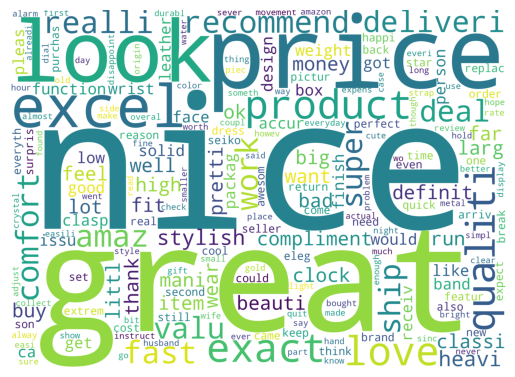

In [51]:
# Generating the wordcloud with the values under the category dataframe for Topic 0
firstcloud = WordCloud(
                          stopwords=stopwords,
                          background_color='White',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

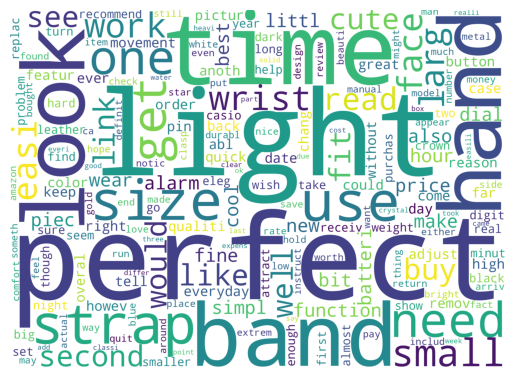

In [52]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=stopwords,
                          background_color='White',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

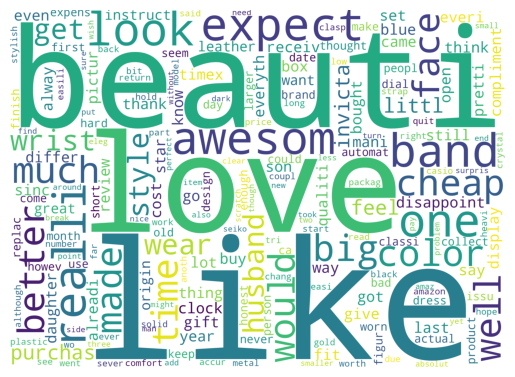

In [53]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=stopwords,
                          background_color='White',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

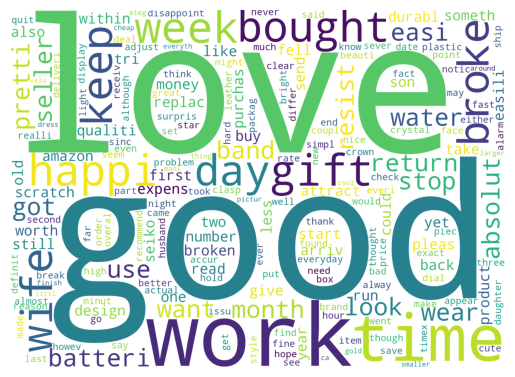

In [54]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=stopwords,
                          background_color='White',
                          width=2500,
                          height=1800
                         ).generate(" ".join(fourth_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [55]:
# Topic and words visualization 2
!pip install gensim

from wordcloud import WordCloud
import matplotlib.colors as mcolors
import gensim

In [56]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

id2word_dict = {i: word for i, word in enumerate(tf_selected_words)}

# Convert the sklearn LDA model to a gensim LDA model

gensim_lda = gensim.models.ldamodel.LdaModel(
    id2word = id2word_dict,
    num_topics=lda.n_components,
    alpha=lda.doc_topic_prior_,
    eta=lda.topic_word_prior_,
    iterations=100,
    random_state=0
)

gensim_lda.state.sstats = lda.components_  # Transfer topic-word distributions

topics = gensim_lda.show_topics(num_words=50, formatted=False)

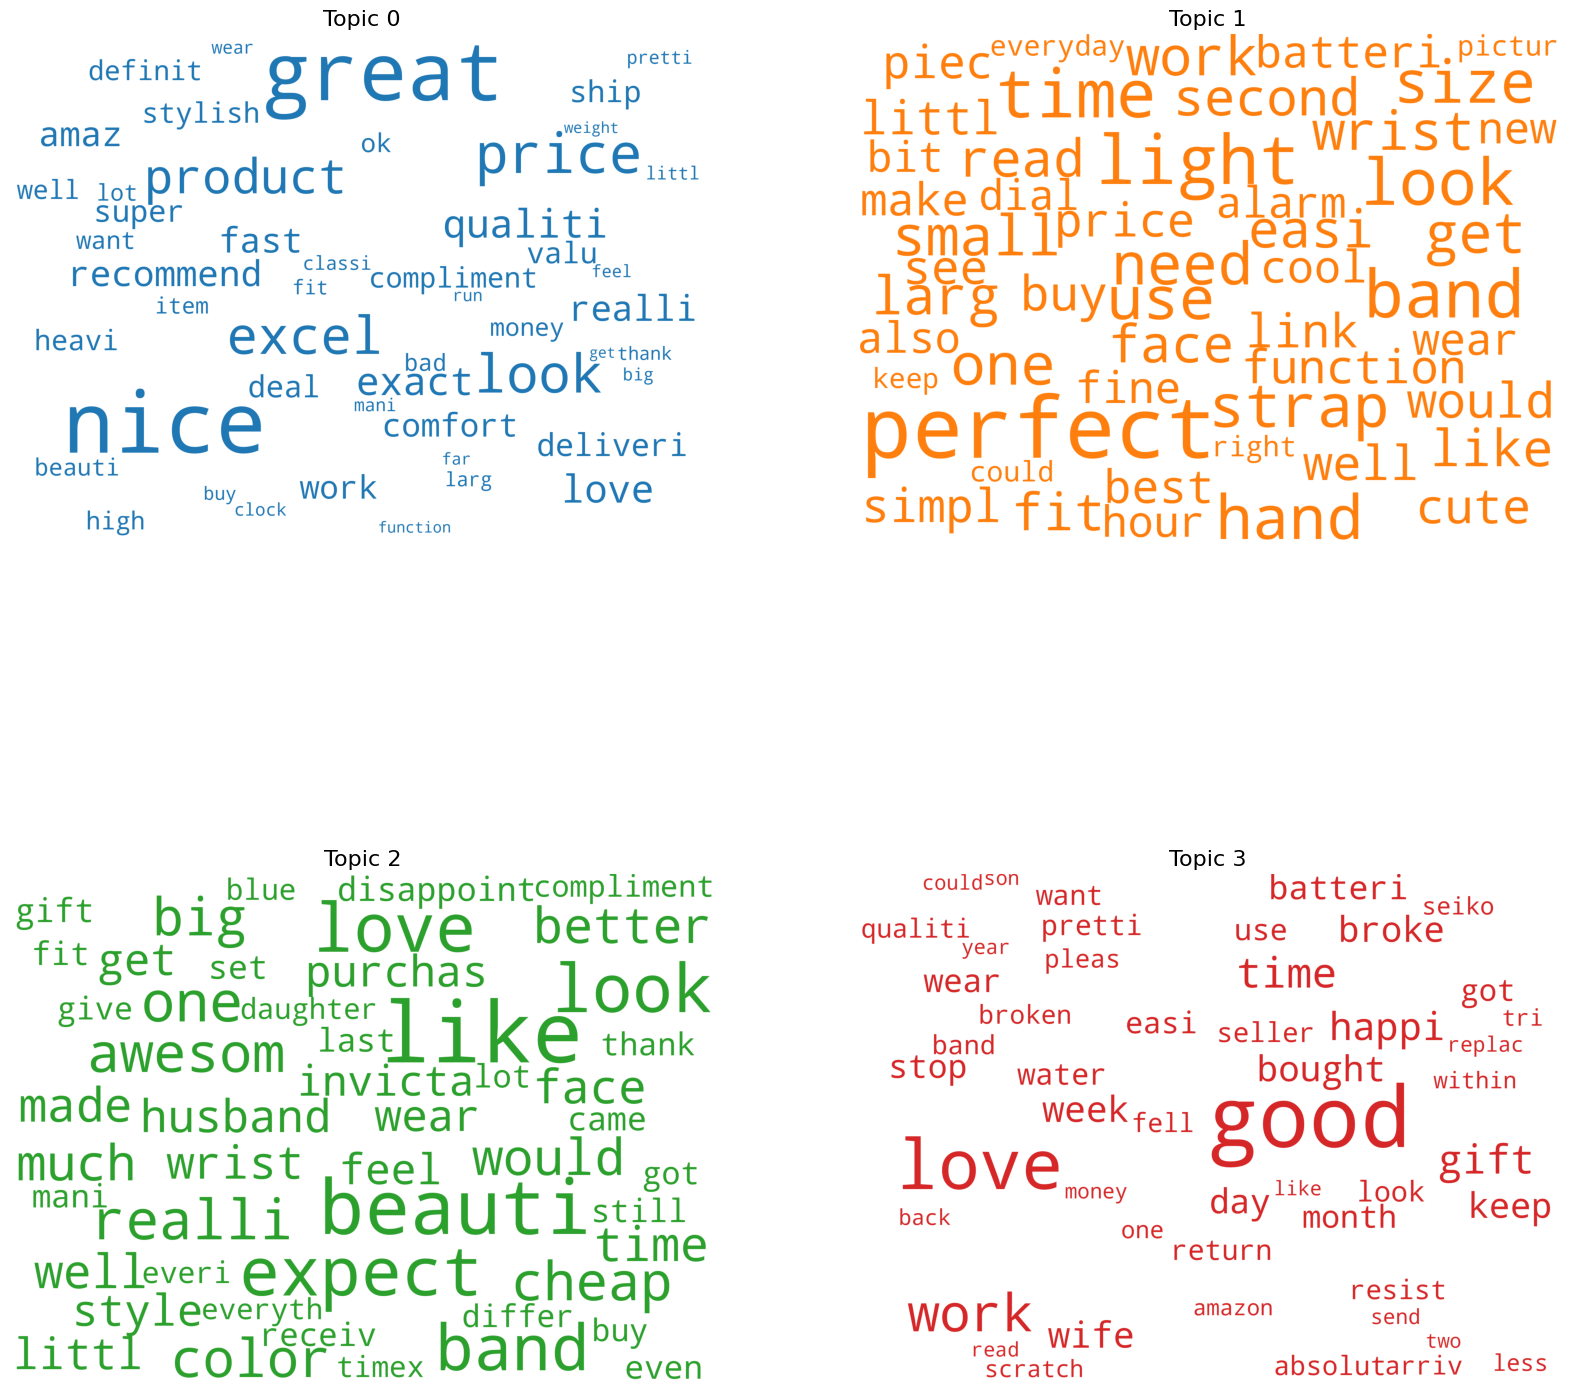

In [57]:
# Determine the number of rows and columns for the subplots based on number of topics
num_topics = len(topics)
num_cols = 2
num_rows = (num_topics + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < num_topics:  # Only plot if there are topics left
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

In [58]:
# Topic and words visualization 3 - 4D Scatterplot

from sklearn.decomposition import PCA
import plotly.express as px
from IPython.display import Image

In [59]:
pca = PCA(n_components=4)

In [60]:
pca.fit(tfidf_matrix.toarray())
xpca = pca.transform(tfidf_matrix.toarray())

In [61]:
PC1_label = "PC1 {}%". format(round((100*pca.explained_variance_ratio_[0]), 2))
PC2_label = "PC2 {}%". format(round((100*pca.explained_variance_ratio_[1]), 2))
PC3_label = "PC3 {}%". format(round((100*pca.explained_variance_ratio_[2]), 2))
PC4_label = "PC4 {}%". format(round((100*pca.explained_variance_ratio_[3]), 2))

In [62]:
df_pca = pd.DataFrame(xpca)
df_pca.columns = [PC1_label, PC2_label, PC3_label, PC4_label]

In [63]:
clu = df_document_topic['topic'].astype(str)  # convert the integer column to a string column
clu.head()

,topic
Doc0,3
Doc1,3
Doc2,3
Doc3,1
Doc4,1


In [64]:
figPCA = px.scatter_3d(df_pca, x=PC1_label, y=PC2_label, z=PC3_label, color=clu)
# figPCA.show()

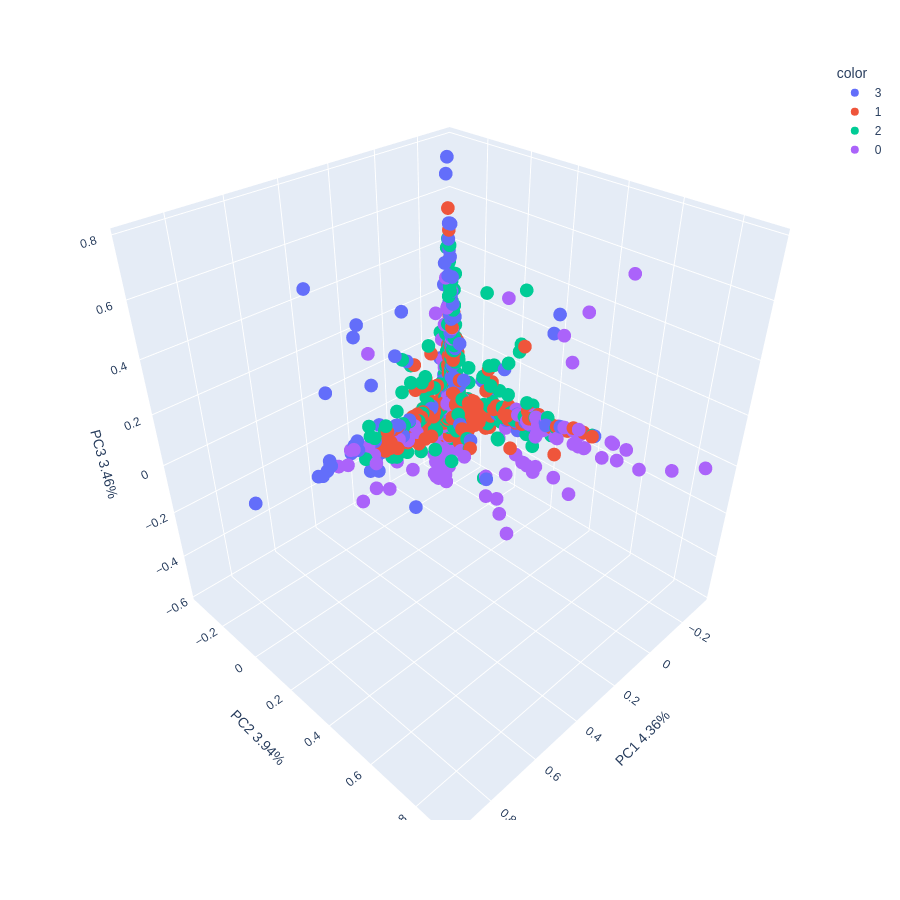

In [65]:
img_bytes = figPCA.to_image(format="png", width=900, height=900, scale=1)
Image(img_bytes)

# Business Recommendation:
### 1. The watch is good product, many customers like it!
### 2. LDA cross-validation: Some custoemrs are couples, we can deliver targeted advertising on Valentine's Day
### 3. Constructive instruction: Some customers feel disappointed, the quality of this watch product need to improve after a long-term use, we can provide after-purchase service to improve customer satisfaction